In [96]:
# 使用LSTM预测电力负荷
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [112]:
# 生成t-x数据
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# 设置随机种子，保证复现
np.random.seed(7)

In [98]:
# 载入数据
df = pd.read_csv(r"./泰迪杯数据01.csv")
df = df.rename(columns={'日期1':'date'})

In [99]:
df.iloc[:98, :].tail()

,date,总有功功率（kw）,最高温度,最低温度,白天风力风向,夜晚风力风向,天气1,天气2
93,2018/1/1 23:15:00,213662.3933,22,12,0,0,2,2
94,2018/1/1 23:30:00,209709.2317,22,12,0,0,2,2
95,2018/1/1 23:45:00,205839.6378,22,12,0,0,2,2
96,2018/1/2 00:00:00,207655.1990,22,15,0,0,2,2
97,2018/1/2 00:15:00,200673.8192,22,15,0,0,2,2


In [100]:
# 数据整理

df['date1'] = df['date'].apply(lambda x: x.split(" ")[0])
df['time'] = df['date'].apply(lambda x: x.split(" ")[1])

In [101]:
df

,date,总有功功率（kw）,最高温度,最低温度,白天风力风向,夜晚风力风向,天气1,天气2,date1,time
0,2018/1/1 00:00:00,244033.7682,22,12,0,0,2,2,2018/1/1,00:00:00
1,2018/1/1 00:15:00,232720.6402,22,12,0,0,2,2,2018/1/1,00:15:00
2,2018/1/1 00:30:00,231685.6891,22,12,0,0,2,2,2018/1/1,00:30:00
3,2018/1/1 00:45:00,227581.3317,22,12,0,0,2,2,2018/1/1,00:45:00
4,2018/1/1 01:00:00,233482.4269,22,12,0,0,2,2,2018/1/1,01:00:00
...,...,...,...,...,...,...,...,...,...,...
1339,2018/1/14 22:45:00,261445.6821,20,10,0,0,2,2,2018/1/14,22:45:00
1340,2018/1/14 23:00:00,261757.4549,20,10,0,0,2,2,2018/1/14,23:00:00
1341,2018/1/14 23:15:00,252103.9613,20,10,0,0,2,2,2018/1/14,23:15:00
1342,2018/1/14 23:30:00,248351.5415,20,10,0,0,2,2,2018/1/14,23:30:00


In [102]:
# 检查基本统计特征，看是否数据异常
df.groupby('date1').date.count()

date1
2018/1/1     96
2018/1/10    96
2018/1/11    96
2018/1/12    96
2018/1/13    96
2018/1/14    96
2018/1/2     96
2018/1/3     96
2018/1/4     96
2018/1/5     96
2018/1/6     96
2018/1/7     96
2018/1/8     96
2018/1/9     96
Name: date, dtype: int64

In [103]:
# 提取0点值,准备数据可视化
date0 = df[df['time'] == "00:00:00"]
date0.index

Int64Index([0, 96, 192, 288, 384, 480, 576, 672, 768, 864, 960, 1056, 1152,
            1248],
           dtype='int64')

In [105]:
# 准备建模需要的数据格式
dataset = df.loc[:, '总有功功率（kw）'].values
dataset = dataset.reshape(dataset.shape[0], 1)
dataset = dataset.astype("float32")

In [106]:
dataset

array([[244033.77],
       [232720.64],
       [231685.69],
       ...,
       [252103.97],
       [248351.55],
       [246574.58]], dtype=float32)

In [117]:
from sklearn.model_selection import train_test_split
# LSTM对输入数据的大小敏感，需要对输入数据做标准化处理
# 使用MinMaxScaler将数据映射到0-1区间
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# 将数据分为训练集、测试集
train, test = train_test_split(dataset, test_size=0.2)

In [118]:
train.shape, test.shape

((1075, 1), (269, 1))

In [119]:
# 经绘图，发现t-1周期性体现在24小时。因为数据粒度是15分钟，因此96条数据是一天
look_back = int(24*60/15) # 96
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [120]:
trainX.shape,testX.shape

((978, 96), (172, 96))

In [122]:
# LSTM网络的输入为【批次大小(行数)，时间步长，特征数量(列数)】
# 将数据转换为符合输入的格式
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [123]:
# 创建LSTM模型，拟合数据
model = Sequential()

# 添加4个LSTM神经元的隐层网络
model.add(LSTM(4, input_shape=(1, look_back)))

# 添加输出层，输出一个预测值
model.add(Dense(1))
# 损失函数与adam优化器
model.compile(loss='mean_squared_error', optimizer='adam')
# 训练数据100期, batch_size:一次训练抓取的样本数量
model.fit(trainX, trainY, epochs=100, batch_size=1)

Epoch 1/100
978/978 [==============================] - 2s 883us/step - loss: 0.0502
Epoch 2/100
978/978 [==============================] - 1s 909us/step - loss: 0.0447
Epoch 3/100
978/978 [==============================] - 1s 888us/step - loss: 0.0425
Epoch 4/100
978/978 [==============================] - 1s 876us/step - loss: 0.0409
Epoch 5/100
978/978 [==============================] - 1s 883us/step - loss: 0.0408
Epoch 6/100
978/978 [==============================] - 1s 880us/step - loss: 0.0405
Epoch 7/100
978/978 [==============================] - 1s 879us/step - loss: 0.0401
Epoch 8/100
978/978 [==============================] - 1s 878us/step - loss: 0.0397
Epoch 9/100
978/978 [==============================] - 1s 885us/step - loss: 0.0397
Epoch 10/100
978/978 [==============================] - 1s 882us/step - loss: 0.0396
Epoch 11/100
978/978 [==============================] - 1s 902us/step - loss: 0.0397
Epoch 12/100
978/978 [==============================] - 1s 920us/step - lo

978/978 [==============================] - 1s 874us/step - loss: 0.0202
Epoch 98/100
978/978 [==============================] - 1s 899us/step - loss: 0.0208
Epoch 99/100
978/978 [==============================] - 1s 913us/step - loss: 0.0202
Epoch 100/100
978/978 [==============================] - 1s 894us/step - loss: 0.0198


In [124]:
# 预测
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 前面把数据缩放到0-1范围。
# 现在跟实际值做比较，将预测值反标准化，从0-1范围转换为原数据范围
itrainPredict = scaler.inverse_transform(trainPredict)
itrainY = scaler.inverse_transform([trainY])
itestPredict = scaler.inverse_transform(testPredict)
itestY = scaler.inverse_transform([testY])

In [125]:
# 评估RMSE误差
trainScore = math.sqrt(mean_squared_error(itrainY[0], itrainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(itestY[0], itestPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.15 RMSE
Test Score: 0.24 RMSE


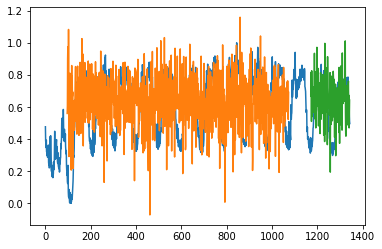

In [140]:
# 准备画图 - 训练数据
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(itrainPredict)+look_back, :] = itrainPredict

# 准备画图 - 测试数据
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(itrainPredict)+(look_back*2)+1:len(dataset)-1, :] = itestPredict

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlim()
plt.show()

In [133]:
# 特征工程优化
# 数据平滑ma2 ma5 
ma2 = (df['总有功功率（kw）'][:df.shape[0]-1].values + df['总有功功率（kw）'][1:].values)/2
ma2 = np.append(ma2, ma2[-1])
ma2.shape

(1344,)

In [134]:
df["ma2"] = ma2

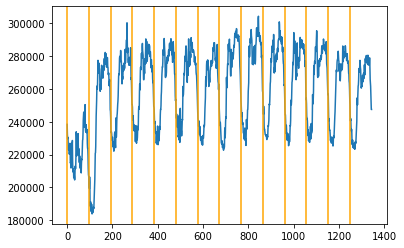

In [136]:
plt.plot(df.index, df.ma2)
for i in date0.index:
    plt.axvline(i, color="orange")
# 干预分析